In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

In [2]:
import shutil

def delete_directory(directory_path):
    shutil.rmtree(directory_path)
    print(f"Directory {directory_path} and its contents have been deleted.")

directory_to_delete = "test_path"
delete_directory(directory_to_delete)

Directory test_path and its contents have been deleted.


In [3]:
from cacheable_model import CacheableModel

In [4]:
import cacheable_model

In [5]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(
            cellmates.index(self)
        )  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            if other == self:
                print("I JUST GAVE MONEY TO MYSELF HEHEHE!")

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
model = MoneyModel(100, 10, 10)


In [7]:
def condition_function(model_vars):
        return model_vars.get('Gini', 0)[-1] > 0.7

In [8]:
cacheable_model = CacheableModel(model, "test_path", 5555, condition_function)

In [9]:
for i in range(5555):
    print(i)
    cacheable_model.model.step()
    cacheable_model.cache()


0
model_vars.get('Gini', 0)[-1]=0.0
Condition not met at step 1. No data to save.
1
model_vars.get('Gini', 0)[-1]=0.32720000000000005
Condition not met at step 2. No data to save.
2
model_vars.get('Gini', 0)[-1]=0.4626
Condition not met at step 3. No data to save.
3
model_vars.get('Gini', 0)[-1]=0.4626
Condition not met at step 4. No data to save.
4
model_vars.get('Gini', 0)[-1]=0.508
Condition not met at step 5. No data to save.
5
model_vars.get('Gini', 0)[-1]=0.5302
Condition not met at step 6. No data to save.
6
model_vars.get('Gini', 0)[-1]=0.5518000000000001
Condition not met at step 7. No data to save.
7
model_vars.get('Gini', 0)[-1]=0.5973999999999999
Condition not met at step 8. No data to save.
8
model_vars.get('Gini', 0)[-1]=0.6082000000000001
Condition not met at step 9. No data to save.
9
model_vars.get('Gini', 0)[-1]=0.6000000000000001
Condition not met at step 10. No data to save.
10
model_vars.get('Gini', 0)[-1]=0.6046
Condition not met at step 11. No data to save.
11
mo

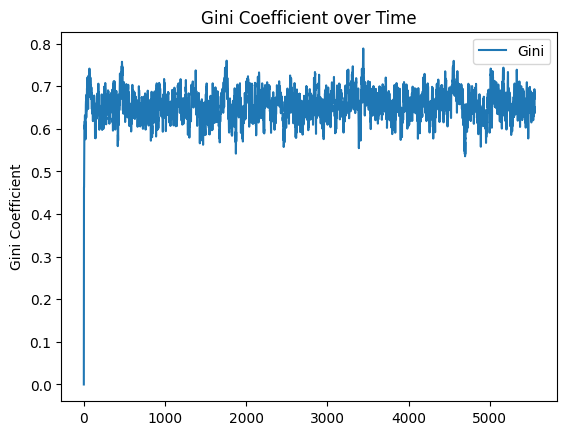

In [10]:

gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [11]:
gini

,Gini
0,0.0000
1,0.3272
2,0.4626
3,0.4626
4,0.5080
...,...
5550,0.6930
5551,0.6732
5552,0.6606
5553,0.6368


In [12]:
import pyarrow.parquet as pq
import pandas as pd
import glob

# Get a list of all Parquet files
model_files = glob.glob('test_path/model_data_*.parquet')
agent_files = glob.glob('test_path/agent_data_*.parquet')

# Initialize lists to hold dataframes
model_dfs = []
agent_dfs = []

# Read and append each file to the list
for model_file in model_files:
    table = pq.read_table(model_file)
    df = table.to_pandas()
    model_dfs.append(df)

for agent_file in agent_files:
    table = pq.read_table(agent_file)
    df = table.to_pandas()
    agent_dfs.append(df)

# Concatenate all DataFrames
model_df = pd.concat(model_dfs, ignore_index=True)
agent_df = pd.concat(agent_dfs, ignore_index=True)

# Display the combined DataFrames
print(model_df)


        Gini
0     0.0000
1     0.3272
2     0.4626
3     0.4626
4     0.5080
...      ...
5550  0.6930
5551  0.6732
5552  0.6606
5553  0.6368
5554  0.6510

[5555 rows x 1 columns]


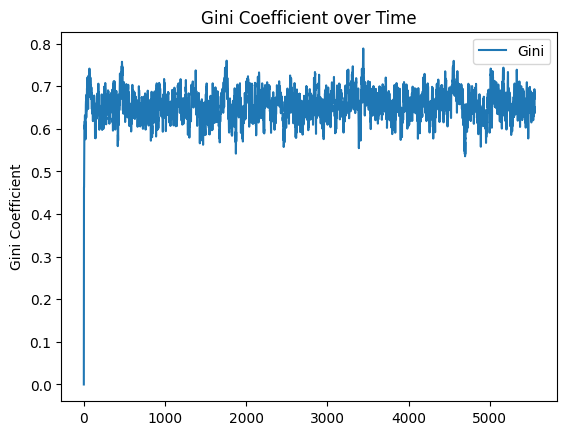

In [13]:
model_df
g = sns.lineplot(data=model_df)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [14]:
model_df

,Gini
0,0.0000
1,0.3272
2,0.4626
3,0.4626
4,0.5080
...,...
5550,0.6930
5551,0.6732
5552,0.6606
5553,0.6368


In [15]:
model_files

['test_path/model_data_001.parquet',
 'test_path/model_data_002.parquet',
 'test_path/model_data_003.parquet',
 'test_path/model_data_004.parquet',
 'test_path/model_data_005.parquet',
 'test_path/model_data_006.parquet',
 'test_path/model_data_007.parquet',
 'test_path/model_data_008.parquet',
 'test_path/model_data_009.parquet',
 'test_path/model_data_010.parquet',
 'test_path/model_data_011.parquet',
 'test_path/model_data_012.parquet',
 'test_path/model_data_013.parquet',
 'test_path/model_data_014.parquet',
 'test_path/model_data_015.parquet',
 'test_path/model_data_016.parquet',
 'test_path/model_data_017.parquet',
 'test_path/model_data_018.parquet',
 'test_path/model_data_019.parquet',
 'test_path/model_data_020.parquet',
 'test_path/model_data_021.parquet',
 'test_path/model_data_022.parquet',
 'test_path/model_data_023.parquet',
 'test_path/model_data_024.parquet',
 'test_path/model_data_025.parquet',
 'test_path/model_data_026.parquet',
 'test_path/model_data_027.parquet',
 

In [16]:
model_df

,Gini
0,0.0000
1,0.3272
2,0.4626
3,0.4626
4,0.5080
...,...
5550,0.6930
5551,0.6732
5552,0.6606
5553,0.6368


In [17]:
(gini == model_df).sum()


Gini    5555
dtype: int64

In [18]:
table = pq.read_table("test_path/special_results.parquet")
df = table.to_pandas()
df

,Gini,Step
0,0.7046,42
1,0.7010,43
2,0.7056,44
3,0.7204,45
4,0.7092,46
...,...,...
463,0.7016,5359
464,0.7080,5365
465,0.7112,5366
466,0.7032,5457


In [19]:
model_dfs


[      Gini
 0   0.0000
 1   0.3272
 2   0.4626
 3   0.4626
 4   0.5080
 ..     ...
 95  0.6754
 96  0.6764
 97  0.6834
 98  0.6582
 99  0.6464
 
 [100 rows x 1 columns],
        Gini
 100  0.6650
 101  0.6506
 102  0.6734
 103  0.6656
 104  0.6450
 ..      ...
 195  0.6086
 196  0.6014
 197  0.6130
 198  0.6184
 199  0.6284
 
 [100 rows x 1 columns],
        Gini
 200  0.6256
 201  0.6086
 202  0.6250
 203  0.6060
 204  0.6240
 ..      ...
 295  0.6338
 296  0.6420
 297  0.6716
 298  0.6904
 299  0.6808
 
 [100 rows x 1 columns],
        Gini
 300  0.6764
 301  0.6888
 302  0.6702
 303  0.6726
 304  0.6638
 ..      ...
 395  0.6800
 396  0.6448
 397  0.6418
 398  0.6556
 399  0.6790
 
 [100 rows x 1 columns],
        Gini
 400  0.6890
 401  0.6862
 402  0.6704
 403  0.6486
 404  0.6194
 ..      ...
 495  0.7084
 496  0.6936
 497  0.6788
 498  0.6916
 499  0.6602
 
 [100 rows x 1 columns],
        Gini
 500  0.6610
 501  0.6544
 502  0.6406
 503  0.6584
 504  0.6760
 ..      ...
 595  